In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-cars-price-prediction/test-data.csv
/kaggle/input/used-cars-price-prediction/train-data.csv


# Data Description

| Attribute | Description |
|----------|----------|
|Name	|The brand and model of the car
|Location	|The location in which the car is being sold or is available for purchase
|Year	|The year or edition of the model
|Kilometers_Driven	|The total kilometers driven in the car by the previous owner(s) in KM
|Fuel_Type	|The type of fuel used by the car
|Transmission	|The type of transmission used by the car
|Owner_Type	|Whether the ownership is Firsthand, Second hand or other
|Mileage	|The standard mileage offered by the car company in kmpl or km/kg
|Engine	|The displacement volume of the engine in cc
|Power	|The maximum power of the engine in bhp
|Seats	|The number of seats in the car
|New_Price	|Price of new model
|Price	|The price of the used car in INR Lakhs

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading Data

In [3]:
df = pd.read_csv('/kaggle/input/used-cars-price-prediction/train-data.csv')
df_test = pd.read_csv('/kaggle/input/used-cars-price-prediction/test-data.csv')

# Exploring Data

In [4]:
df.head()# Will give you first 5 records

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [5]:
#gain insights of your data set and see general information about each feature and the total number of non-null values in each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


Well, as a first note we can see that we are out of luck, because we have missing values in some columns (__Mileage, Engine, Power, Seats, New_Price__). Let's see which of these variables contain missing values.
More on these values later.
__Data type__ for __Mileage , Engine and Power__ columns need to be fixed

In [6]:
#You can get idea that gives summary statstics for only intersting numerical features in your data set.
df.describe()

,Unnamed: 0,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,3009.000000,2013.358199,5.873838e+04,5.278735,9.479468
std,1737.679967,3.269742,9.126884e+04,0.808840,11.187917
min,0.000000,1998.000000,1.710000e+02,0.000000,0.440000
25%,1504.500000,2011.000000,3.400000e+04,5.000000,3.500000
50%,3009.000000,2014.000000,5.300000e+04,5.000000,5.640000
75%,4513.500000,2016.000000,7.300000e+04,5.000000,9.950000
max,6018.000000,2019.000000,6.500000e+06,10.000000,160.000000


 * Year Range : 1998 - 2019
 * Kilometers_Driven Range : 171 - 650000
 * Seats Range : 0 - 10  (0 is not logical)
 * Price Range : 0.44 - 160

In [7]:
df.drop('Unnamed: 0' , axis =1 , inplace = True )

# Data Cleaning

In [8]:
df_clean = df.copy()

In [9]:
df_clean.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


## Check Missing Values

In [10]:
df_clean.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

- EarlierFrom the dataset info, we observed some features have missing values. This section will be imputing the missing values with appropriate values.


In [11]:
df_clean.isnull().mean() * 100

Name                  0.000000
Location              0.000000
Year                  0.000000
Kilometers_Driven     0.000000
Fuel_Type             0.000000
Transmission          0.000000
Owner_Type            0.000000
Mileage               0.033228
Engine                0.598106
Power                 0.598106
Seats                 0.697790
New_Price            86.310018
Price                 0.000000
dtype: float64

- We drop the column of __New_Price__ because the missing values from it are __more than 86%__ of the total data
- We drop the missing values of __Mileage,Engine, Power__ and Seats because they are __less than 1%__ of the total data.


In [12]:
df_clean.drop('New_Price' , axis =1 , inplace = True )

In [13]:
df_clean.dropna(subset='Mileage', inplace=True)

In [14]:
df_clean.isnull().sum()

Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

In [15]:
# Convert Milage to int
def convert_milage_to_int(milage):
    new_milage =  float(milage.split(' ')[0])
    if milage.split(' ')[1] == 'km/kg':
        new_milage = new_milage * 0.74

    return new_milage


df_clean['Mileage'] = df_clean['Mileage'].apply(convert_milage_to_int)

In [16]:
df_clean.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,19.684,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.670,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.200,1199 CC,88.7 bhp,5.0,4.50


In [17]:
df_clean[df_clean.Seats == 0]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
3999,Audi A4 3.2 FSI Tiptronic Quattro,Hyderabad,2012,125000,Petrol,Automatic,First,10.5,3197 CC,null bhp,0.0,18.0


In [18]:
df_clean.Seats = df_clean.Seats.replace(0, np.nan)

In [19]:
df_clean.Seats.value_counts().sort_values(ascending=False)

5.0     5012
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
Name: Seats, dtype: int64

### Check Duplicated

In [20]:
df_clean.duplicated().sum()

0

- No duplicates. Now let's fix data types for  __Engine and power__ columns.

In [21]:
df_clean['Engine'] = df_clean['Engine'].str.rstrip(' CC')
df_clean['Power'] = df_clean['Power'].str.rstrip(' bhp')

In [22]:
df_clean.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,19.684,998,58.16,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.670,1582,126.2,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.200,1199,88.7,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.770,1248,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.200,1968,140.8,5.0,17.74


In [23]:
df_clean['Engine'] = df_clean['Engine'].astype('float')

In [24]:
df_clean['Power']=pd.to_numeric(df_clean['Power'] , errors = 'coerce') 

In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6017 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6017 non-null   object 
 1   Location           6017 non-null   object 
 2   Year               6017 non-null   int64  
 3   Kilometers_Driven  6017 non-null   int64  
 4   Fuel_Type          6017 non-null   object 
 5   Transmission       6017 non-null   object 
 6   Owner_Type         6017 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5981 non-null   float64
 9   Power              5874 non-null   float64
 10  Seats              5974 non-null   float64
 11  Price              6017 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 611.1+ KB


# Feature Engineering


In [26]:
df_clean['Name'].nunique()

1874

In [27]:
df_clean['brand'] = df_clean['Name'].str.split(' ').str[0]

In [28]:
df_clean['brand'].nunique()

31

In [29]:
df_clean.drop('Name' , axis =1 , inplace = True )

In [30]:
df_clean.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,brand
0,Mumbai,2010,72000,CNG,Manual,First,19.684,998.0,58.16,5.0,1.75,Maruti
1,Pune,2015,41000,Diesel,Manual,First,19.670,1582.0,126.20,5.0,12.50,Hyundai
2,Chennai,2011,46000,Petrol,Manual,First,18.200,1199.0,88.70,5.0,4.50,Honda
3,Chennai,2012,87000,Diesel,Manual,First,20.770,1248.0,88.76,7.0,6.00,Maruti
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.200,1968.0,140.80,5.0,17.74,Audi


# Data Visualisation and Questions 

- The term Univariate Analysis refers to the analysis of only one variable. The aim is to analyse and find out patterns specific to a single variable

In [31]:
cat_cols = df_clean.select_dtypes(include='object').columns.tolist()
cat_cols

['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'brand']

In [32]:
for col in cat_cols:
    print(df_clean[col].value_counts())
    print('------------------------------------------------------------')

Mumbai        789
Hyderabad     742
Kochi         651
Coimbatore    636
Pune          622
Delhi         554
Kolkata       535
Chennai       493
Jaipur        413
Bangalore     358
Ahmedabad     224
Name: Location, dtype: int64
------------------------------------------------------------
Diesel    3205
Petrol    2746
CNG         56
LPG         10
Name: Fuel_Type, dtype: int64
------------------------------------------------------------
Manual       4299
Automatic    1718
Name: Transmission, dtype: int64
------------------------------------------------------------
First             4927
Second             968
Third              113
Fourth & Above       9
Name: Owner_Type, dtype: int64
------------------------------------------------------------
Maruti           1211
Hyundai          1107
Honda             608
Toyota            410
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          271
BMW               267
Audi              236
Tata              186
Skoda

- __Q.1 Which Location are more in demand?__

In [33]:
def colpie (col ):
    fig = px.pie(data_frame = df_clean , names = col)
    fig.show()

In [34]:
colpie('Location')

- The most popular location for selling cars is mumbai

- __Q.2 Which Fuel_Type are more in demand?__

In [35]:
colpie('Fuel_Type')

 - The most popular Fuel_Type is Diesel

- __Q.3 Which Transmission are more in demand?__

In [36]:
colpie('Transmission')

- More than half of the types of transmissions used by the car is manual

- __Q.4 Which Owner_Type are more in demand?__

In [37]:
colpie('Owner_Type')

- More than 80% of the ownership was direct

### summary of catigorical values

In [38]:
num_cols = df_clean.select_dtypes(exclude = 'O').columns.tolist()
num_cols

['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']

In [39]:
for col in num_cols:
    print(df_clean[col].value_counts())
    print('------------------------------------------------------------')

2014    797
2015    744
2016    740
2013    649
2017    587
2012    580
2011    465
2010    342
2018    298
2009    198
2008    174
2007    125
2019    102
2006     78
2005     57
2004     31
2003     17
2002     15
2001      8
2000      4
1998      4
1999      2
Name: Year, dtype: int64
------------------------------------------------------------
60000    82
45000    70
65000    68
55000    60
50000    60
         ..
28937     1
82085     1
68465     1
63854     1
27365     1
Name: Kilometers_Driven, Length: 3093, dtype: int64
------------------------------------------------------------
18.900    172
17.000    172
18.600    119
20.360     88
21.100     86
         ... 
9.768       1
27.280      1
14.570      1
16.872      1
17.240      1
Name: Mileage, Length: 439, dtype: int64
------------------------------------------------------------
1197.0    606
1248.0    512
1498.0    304
998.0     259
2179.0    240
         ... 
1489.0      1
1422.0      1
1978.0      1
2694.0      1
1797.0   

### summary of numerical values

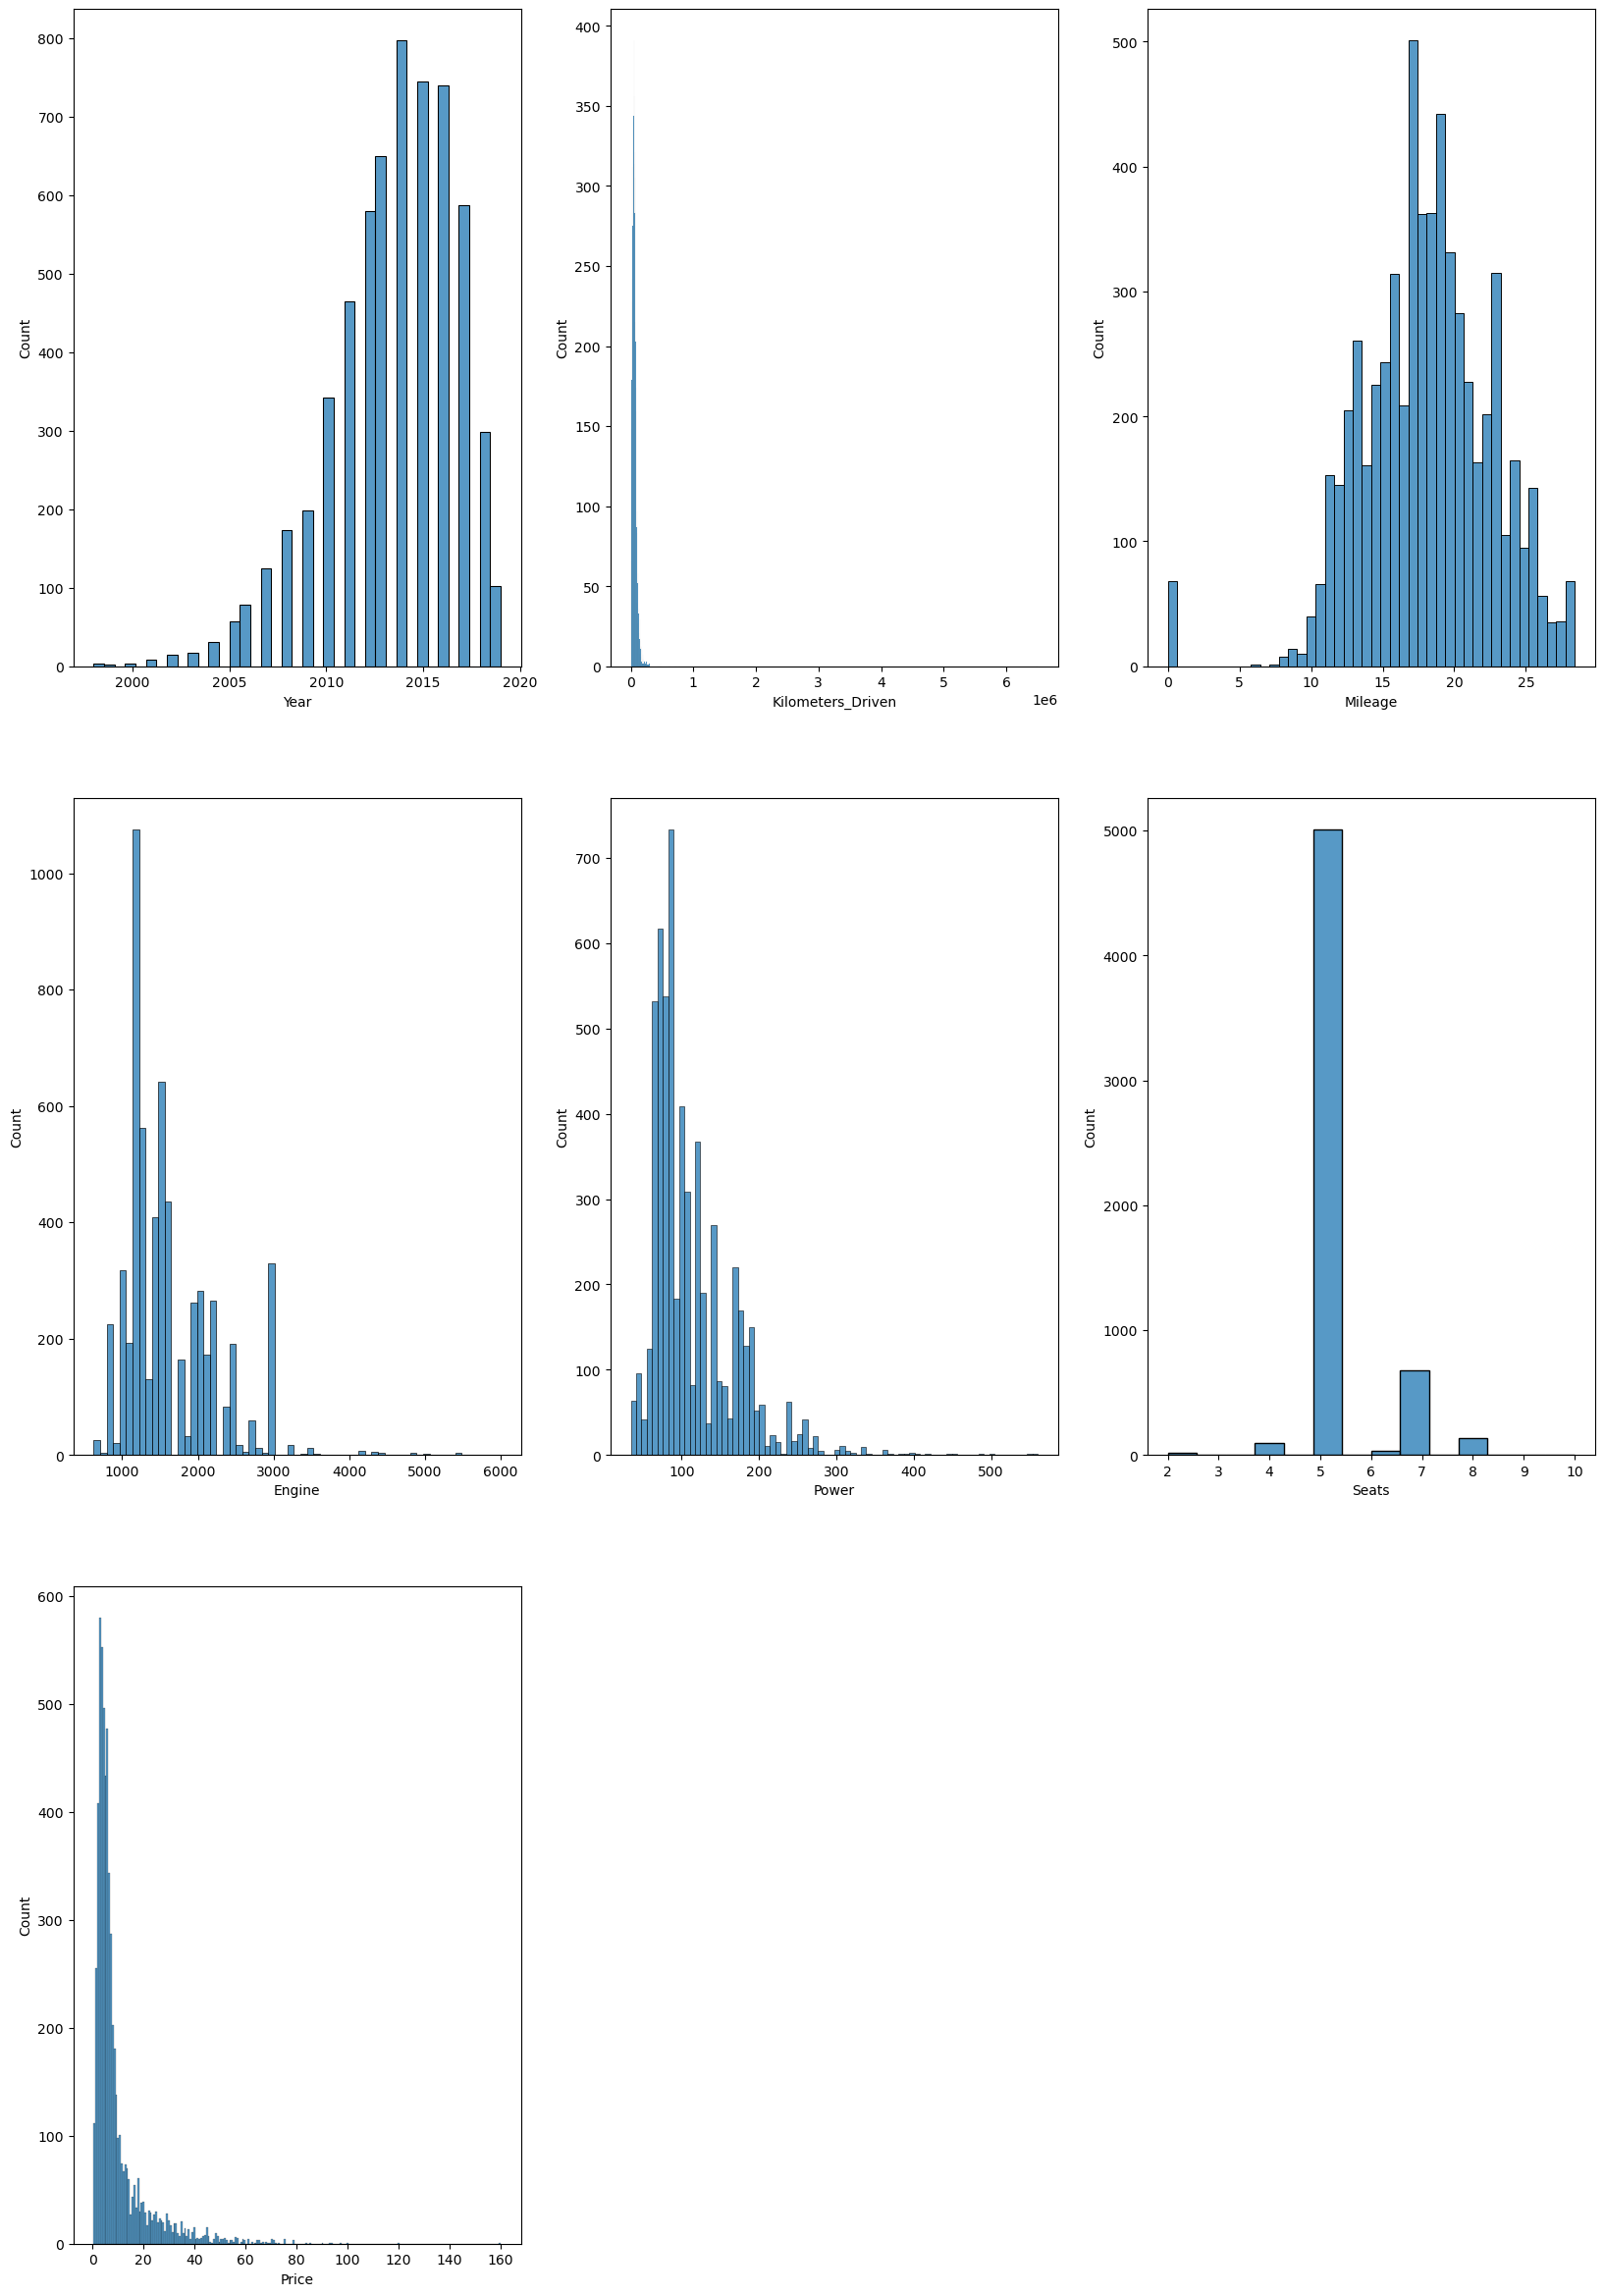

In [40]:
plt.figure(figsize = (20 , 40))
for i , col in enumerate (num_cols  ,1) :
    plt.subplot((len(num_cols)//2+1) , 3 , i )
    sns.histplot(data = df_clean , x = col)

## Bivariate Analysis

- __Q.5 Is there a significant relationship between a Location and their likelihood to price ?__

In [41]:
loc_price = df_clean.groupby('Location')['Price'].mean().sort_values(ascending=False)
fig = px.bar(loc_price , color = loc_price.index )
fig.show()

- Cars in Coimbatore are higher priced than cars in other regions.
- Cars in Hyderabad , Delhi are the similar in price.
- Cars in Pune , Chennai are the same price 

- __Q.6 Is there a significant relationship between a Fuel_Type and their likelihood to price ?__

In [42]:
fuel_price = df_clean.groupby('Fuel_Type')['Price'].mean().sort_values(ascending=False)
fig = px.bar(fuel_price , color = fuel_price.index )
fig.show()

- The cars that use fuel-type diesel have higher prices.

- __Q.8Is there a significant relationship between a Transmission and their likelihood to price ?__

In [43]:
trans_price = df_clean.groupby('Transmission')['Price'].mean().sort_values(ascending=False)
fig = px.pie(trans_price , names= trans_price.index , values= trans_price.values)
fig.show()

- The cars that have a transmission automatic are higher priced than the cars that have a transmission Manual.

- __Q.9 Is there a significant relationship between a Owner_Type and their likelihood to price ?__

In [44]:
owner_price = df_clean.groupby('Owner_Type')['Price'].mean().sort_values(ascending=False)
fig = px.pie(owner_price , names= owner_price.index , values= owner_price.values)
fig.show()

- The cars that had only one owner have a higher price than the cars that had multiple owners.

- __Q.10 Is there a significant relationship between a brand and their likelihood to price ?__

In [45]:
brand_price = df_clean.groupby('brand')['Price'].mean().sort_values(ascending=False)
fig = px.bar(brand_price , color = brand_price.index )
fig.show()

- The cars from the type lamborghini have a higher price.

- __Q.11 Does the Year of a customer have a significant impact on their likelihood to Price?__

In [46]:
year_price = df_clean.groupby('Year')['Price'].mean()
fig = px.bar(year_price , color = year_price.index )
fig.show()

- There is a positive relationship between the price of the car and the year of the car, as the price of the car increases every year.


- __Q.12 Does the Kilometers_Driven of a customer have a significant impact on their likelihood to Price?__

In [47]:
fig = px.scatter(df_clean , x = np.log(df_clean['Kilometers_Driven']),y= np.log(df_clean['Price']) ,trendline='ols')
fig.show()

- The relation between kilometers driven and car price is a measure of how much a car has been driven. In general, as the number of kilometers driven increases, the price of the car tends to decrease.

- __Q.13 Does the Mileage of a customer have a significant impact on their likelihood to Price?__

In [48]:
fig = px.scatter(df_clean , x =(df_clean['Mileage']),y= (df_clean['Price']), trendline='ols')
fig.show()

- The mileage driven is negatively correlated with the car price, i.e. the price of the car tends to decrease as the mileage increases. This is because higher mileage indicates that the car is being driven more frequently, which causes greater wear and tear on the engine, transmission and other components

- __Q.14 Does the Engine of a customer have a significant impact on their likelihood to Price?__

In [49]:
fig = px.scatter(df_clean , x = np.log(df_clean['Engine']),y= np.log(df_clean['Price']), trendline='ols')
fig.show()

- The relationship between the engine and the price of the car is positively correlated, which means that the car engine is one of the factors that can affect the price of the car. Generally speaking, a more powerful engine increases the price of a car.

- __Q.15 Does the Power  of a customer have a significant impact on their likelihood to Price?__

In [50]:
fig = px.scatter(df_clean , x = np.log(df_clean['Power']),y= np.log(df_clean['Price']) ,trendline='ols')
fig.show()

- Cars with greater power tend to cost more than cars with less power since there is a positive relationship between a car's power and price. This is because more powerful vehicles frequently feature larger engines and cutting-edge technology, which can raise the cost of producing them./

- __Q.16 Does the Seats of a customer have a significant impact on their likelihood to Price?__

In [51]:
seet_price = df_clean.groupby('Seats')['Price'].mean()
fig = px.bar(seet_price , color = seet_price.index )
fig.show()

- The cars from the __Seats 2__ have a higher price.

# Data Splitting

In [52]:
# Data Splitting into features and target
X = df_clean.drop('Price', axis=1)
y = df_clean['Price']

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Fuel_Type'])

# Data Preprocessing

In [53]:
numerical_cols = list(df_clean.select_dtypes(include=['int64', 'float64']).columns)
numerical_cols.remove('Price')
numerical_cols

['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats']

In [54]:
categorical_cols = list(df_clean.select_dtypes(include=['object']).columns)
categorical_cols

['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'brand']

## Handling Missing Values

In [55]:
df_clean.isnull().sum()

Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                0
Engine                36
Power                143
Seats                 43
Price                  0
brand                  0
dtype: int64

In [56]:
missing_cols = ['Mileage', 'Engine', 'Power', 'Seats']

In [57]:
# Impute missing values using SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train[missing_cols] = imputer.fit_transform(X_train[missing_cols])
X_test[missing_cols] = imputer.transform(X_test[missing_cols])


In [58]:
X_train.isnull().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
brand                0
dtype: int64

In [59]:
X_test.isnull().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
brand                0
dtype: int64

# Scaling Data

In [60]:
# Standardize numerical columns

scaler = MinMaxScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [61]:
X_train.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,0.729809,0.009036,0.636419,0.185276,0.149618,0.409650
std,0.156275,0.015384,0.159148,0.110951,0.099876,0.099643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.619048,0.005205,0.535211,0.106811,0.085013,0.375000
50%,0.761905,0.008128,0.639437,0.161705,0.122480,0.375000
75%,0.857143,0.011205,0.742958,0.250093,0.197471,0.375000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Handling Categorical Data

In [62]:
X_train.Owner_Type.value_counts()

First             3921
Second             781
Third              102
Fourth & Above       9
Name: Owner_Type, dtype: int64

In [63]:
# Ordinal Encoding for Owner_Type 
ordinal_encoder = OrdinalEncoder(categories=[['First', 'Second', 'Third', 'Fourth & Above']])
X_train['Owner_Type'] = ordinal_encoder.fit_transform(X_train[['Owner_Type']])
X_test['Owner_Type'] = ordinal_encoder.transform(X_test[['Owner_Type']])

In [64]:
X_train['Owner_Type'].value_counts()

0.0    3921
1.0     781
2.0     102
3.0       9
Name: Owner_Type, dtype: int64

In [65]:
X_train.sample(3)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,brand
5770,Mumbai,0.809524,0.007359,Diesel,Manual,0.0,0.563380,0.289356,0.201217,0.625,Mahindra
5663,Bangalore,0.857143,0.006282,Petrol,Manual,1.0,0.886268,0.032564,0.036326,0.375,Renault
481,Chennai,0.619048,0.011512,Diesel,Manual,1.0,0.704225,0.144213,0.064283,0.375,Ford


In [66]:
# Handling Categorical columns using Binary Encoding

from category_encoders import BinaryEncoder

encoder = BinaryEncoder(cols=['Location', 'Fuel_Type', 'Transmission','brand'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [67]:
X_train

,Location_0,Location_1,Location_2,Location_3,Year,Kilometers_Driven,Fuel_Type_0,Fuel_Type_1,Fuel_Type_2,Transmission_0,...,Owner_Type,Mileage,Engine,Power,Seats,brand_0,brand_1,brand_2,brand_3,brand_4
276,0,0,0,1,0.714286,0.016128,0,0,1,0,...,1.0,0.424296,0.289356,0.163180,0.750,0,0,0,0,1
2351,0,0,1,0,0.761905,0.006789,0,1,0,0,...,1.0,0.665493,0.106624,0.090909,0.375,0,0,0,1,0
1278,0,0,1,1,0.571429,0.013205,0,1,0,0,...,0.0,0.521127,0.218645,0.182579,0.375,0,0,0,1,1
4901,0,1,0,0,0.809524,0.007151,0,1,0,0,...,0.0,0.683099,0.106811,0.100038,0.375,0,0,0,1,1
209,0,1,0,1,0.761905,0.005704,0,1,0,1,...,0.0,0.521127,0.180685,0.164511,0.375,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961,0,0,0,1,0.809524,0.006439,0,1,0,1,...,0.0,0.545775,0.106811,0.099848,0.375,0,0,0,1,1
4102,0,1,0,1,0.666667,0.008100,0,1,0,0,...,0.0,0.579930,0.106811,0.075504,0.375,0,1,0,1,1
2461,0,0,1,1,0.809524,0.008282,0,0,1,0,...,1.0,0.669366,0.155750,0.141308,0.375,1,0,0,0,0
5868,0,1,0,1,0.761905,0.007857,0,0,1,1,...,0.0,0.288732,0.440826,0.400913,0.250,1,0,0,0,1


In [68]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Model Building

In [69]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)


print('Training Score: ', lr.score(X_train, y_train))
print('Testing Score: ', lr.score(X_test, y_test))

Training Score:  0.8725600164243243
Testing Score:  0.8930035601358112


In [70]:
# Ridge

from sklearn.linear_model import Ridge

r = Ridge()
r.fit(X_train, y_train)

print('Training Score: ', r.score(X_train, y_train))
print('Testing Score: ', r.score(X_test, y_test))

Training Score:  0.8723307123276062
Testing Score:  0.892059859300495


In [71]:
# support vector regression (SVR)

from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

print('Training Score: ', svr.score(X_train, y_train))
print('Testing Score: ', svr.score(X_test, y_test))

Training Score:  0.9424130300887287
Testing Score:  0.9446803808980784


In [72]:
# DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)

print('Training Score: ', dt.score(X_train, y_train))
print('Testing Score: ', dt.score(X_test, y_test))

Training Score:  0.9999950578421372
Testing Score:  0.8723335625689148


In [73]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10 ,random_state=42, max_depth=19)

rf.fit(X_train, y_train)

print('Training Score: ', rf.score(X_train, y_train))
print('Testing Score: ', rf.score(X_test, y_test))

Training Score:  0.9854957993215344
Testing Score:  0.9363817768869109


In [74]:
rf.feature_importances_

array([3.43720379e-03, 3.15027842e-03, 2.70410296e-03, 3.17660383e-03,
       2.12783395e-01, 2.14501298e-02, 1.37697436e-05, 2.50187751e-03,
       1.96287151e-03, 7.48568667e-03, 5.76805908e-03, 2.37104525e-03,
       1.83994724e-02, 4.45674772e-02, 6.45137563e-01, 5.47383820e-03,
       4.10459168e-03, 1.70478532e-03, 4.05669578e-03, 6.32889167e-03,
       3.42166033e-03])

In [75]:
pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_.round(3)}).sort_values('Importance', ascending=False)

,Feature,Importance
14,Power,0.645
4,Year,0.213
13,Engine,0.045
5,Kilometers_Driven,0.021
12,Mileage,0.018
9,Transmission_0,0.007
10,Transmission_1,0.006
19,brand_3,0.006
15,Seats,0.005
18,brand_2,0.004


<Axes: >

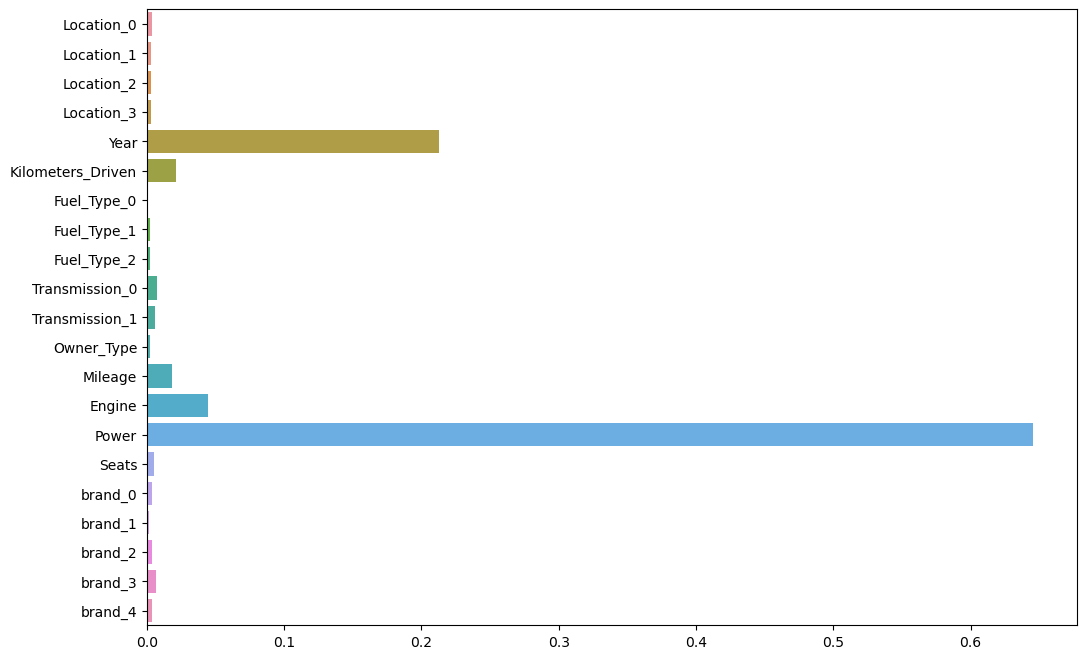

In [76]:
plt.figure(figsize=(12,8))
sns.barplot(x=rf.feature_importances_, y=X_train.columns)

In [77]:
# Voting Regressor

from sklearn.ensemble import  VotingRegressor


lin_reg = LinearRegression()
dt_reg = DecisionTreeRegressor(max_depth=10)
svr_reg = SVR(kernel='rbf')

# Voting Regressor
voting_reg = VotingRegressor(estimators=[('lr', lin_reg), ('dt', dt_reg), ('svr', svr_reg)])

# Fitting the data
voting_reg.fit(X_train, y_train)

# Checking the score
print('Training Score: ', voting_reg.score(X_train, y_train))
print('Testing Score: ', voting_reg.score(X_test, y_test))

Training Score:  0.9523095218322278
Testing Score:  0.9344613785379935


In [78]:
# BaggingRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

lin_reg = LinearRegression()
ridge = Ridge()
lasso = Lasso()
dt_reg = DecisionTreeRegressor(max_depth=10)

bag_reg = BaggingRegressor(dt_reg, n_estimators=100, bootstrap=True, random_state=42,
                           max_features=0.8)
                           

# Fitting the data
bag_reg.fit(X_train, y_train)

# Checking the score
print('Training Score: ', bag_reg.score(X_train, y_train))
print('Testing Score: ', bag_reg.score(X_test, y_test))

Training Score:  0.9697643480826788
Testing Score:  0.9373168215886574


In [79]:
# AdaBoost Regressor

from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators=200, random_state=42)

# Fitting the data
ada_reg.fit(X_train, y_train)

# Checking the score
print('Training Score: ', ada_reg.score(X_train, y_train))
print('Testing Score: ', ada_reg.score(X_test, y_test))

Training Score:  0.8460854976335348
Testing Score:  0.8465355400770136


In [80]:
# GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor

grad_reg = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)

# Fitting the data
grad_reg.fit(X_train, y_train)

# Checking the score
print('Training Score: ', grad_reg.score(X_train, y_train))
print('Testing Score: ', grad_reg.score(X_test, y_test))

Training Score:  0.9568273264239897
Testing Score:  0.9501892377890894


In [81]:
#pip install xgboost

In [82]:
# XGBoost

from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=300, max_depth=3, random_state=42)

# Fitting the data
xgb.fit(X_train, y_train)

# Checking the score
print('Training Score: ', xgb.score(X_train, y_train))
print('Testing Score: ', xgb.score(X_test, y_test))

Training Score:  0.9785408858162858
Testing Score:  0.9576509250341265


In [83]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {
    'n_estimators':[100,200,300 ,400 ,500],
    'max_depth': range(3,10),
}
clf = XGBRegressor()
RCV = RandomizedSearchCV(estimator=clf, 
                   param_distributions=parameters, 
                   n_iter=3,
                   cv=3)

In [84]:
RCV.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...x_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=3,
                   param_distributions={'max_depth': range(3, 10),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})

In [85]:
RCV.best_params_

{'n_estimators': 100, 'max_depth': 5}

In [86]:
# XGBoost

from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=200, max_depth=5, random_state=42)

# Fitting the data
xgb.fit(X_train, y_train)

# Checking the score
print('Training Score: ', xgb.score(X_train, y_train))
print('Testing Score: ', xgb.score(X_test, y_test))

Training Score:  0.9922796918988394
Testing Score:  0.9603590333849822


In [87]:
Models_Summarization = pd.DataFrame(
                {
                    
'Training Accuracy': [round(lr.score(X_train, y_train) * 100, 2), 
                                          round(r.score(X_train, y_train) * 100, 2), 
                                          round(svr.score(X_train, y_train) * 100, 2), 
                                          round(dt.score(X_train, y_train) * 100, 2), 
                                          round(rf.score(X_train, y_train) * 100, 2), 
                                          round(voting_reg.score(X_train, y_train) * 100, 2), 
                                          round(bag_reg.score(X_train, y_train) * 100, 2),
                                          round(ada_reg.score(X_train, y_train) * 100, 2),
                                          round(grad_reg.score(X_train, y_train) * 100, 2),
                                          round(xgb.score(X_train, y_train) * 100, 2)], 
'Teasting Accuracy': [round(lr.score(X_test, y_test) * 100, 2), 
                                         round(r.score(X_test, y_test) * 100, 2), 
                                         round(svr.score(X_test, y_test) * 100, 2), 
                                         round(dt.score(X_test, y_test) * 100, 2), 
                                         round(rf.score(X_test, y_test) * 100, 2), 
                                         round(voting_reg.score(X_test, y_test) * 100, 2), 
                                         round(bag_reg.score(X_test, y_test) * 100, 2), 
                                         round(ada_reg.score(X_test, y_test) * 100, 2),
                                         round(grad_reg.score(X_test, y_test) * 100, 2),
                                         round(xgb.score(X_test, y_test) * 100, 2)], 
              
                },
    
    index = ['Linear Regression', 'Ridge Regression', 'SVR Regression', ' DecisionTreeRegressor', 
         'Random Forest Regressor', 'Voting Regressor', 'BaggingRegressor',
         'AdaBoost Regressor' , 'GradientBoostingRegressor','XGBoost']
            )

In [88]:
Models_Summarization

,Training Accuracy,Teasting Accuracy
Linear Regression,87.26,89.30
Ridge Regression,87.23,89.21
SVR Regression,94.24,94.47
DecisionTreeRegressor,100.00,87.23
Random Forest Regressor,98.55,93.64
Voting Regressor,95.23,93.45
BaggingRegressor,96.98,93.73
AdaBoost Regressor,84.61,84.65
GradientBoostingRegressor,95.68,95.02
XGBoost,99.23,96.04


In [89]:
import pickle


In [90]:
pickle.dump(xgb, open('model.pkl', 'wb'))

## <center>Thanks For Following </center>
